In [1]:
"""loop through files in S1_Dataset directory"""
"""create 2D data matrix by appending each new dataset to the bottom of data matrixx"""
import os
import pandas as pd

S1_PATH = os.path.join('..','Datasets_Healthy_Older_People','S1_Dataset')
S2_PATH = os.path.join('..','Datasets_Healthy_Older_People','S2_Dataset')
print('Importing Data...')
s1_data = pd.DataFrame()
for filename in os.listdir(S1_PATH):
    if filename != 'README.txt':
        data_path = os.path.join(S1_PATH, filename)
        data=pd.read_csv(data_path, header=None)
        s1_data = s1_data.append(data, ignore_index=True)
s1_data.columns = ['time','frontal','vertical','lateral','id','rssi','phase','frequency','activity']
print('Done')
s1_data.info()

Importing Data...
Done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52482 entries, 0 to 52481
Data columns (total 9 columns):
time         52482 non-null float64
frontal      52482 non-null float64
vertical     52482 non-null float64
lateral      52482 non-null float64
id           52482 non-null int64
rssi         52482 non-null float64
phase        52482 non-null float64
frequency    52482 non-null float64
activity     52482 non-null int64
dtypes: float64(7), int64(2)
memory usage: 3.6 MB


In [40]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# s1_data_normalized = pd.DataFrame(min_max_scaler.fit_transform(s1_data))
# s1_data_normalized.columns = ['time','frontal','vertical','lateral','id','rssi','phase','frequency','activity']
# s1_data_normalized


In [7]:
"""Make data sets for training and testing"""
from sklearn.model_selection import train_test_split
s1_train_set, s1_test_set = train_test_split(s1_data, test_size = 0.2, random_state = 1)
s1_train_set_s1nn =  s1_train_set.drop(columns=['time','frequency','phase'])
s1_train_set_s1nn_features = s1_train_set_s1nn.drop(columns=['activity'])
s1_train_set_s1nn_labels = s1_train_set_s1nn.drop(columns=['frontal','vertical','lateral','rssi','id'])

s1_test_set_s1nn =  s1_test_set.drop(columns=['time','frequency','phase'])
s1_test_set_s1nn_features = s1_test_set_s1nn.drop(columns=['activity'])
s1_test_set_s1nn_labels = s1_test_set_s1nn.drop(columns=['frontal','vertical','lateral','rssi','id'])


In [12]:
"""Fit Model on training data"""
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier as MLP

nn_clf = MLP(solver='adam', alpha=1e-5,hidden_layer_sizes=(5,5), random_state=1)
nn_clf = nn_clf.fit(s1_train_set_s1nn_features, s1_train_set_s1nn_labels.values.ravel())

In [9]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[9.76880522e-01 9.16522170e-03 1.27982826e-02 1.15597391e-03]
 [9.77149386e-01 1.77092259e-02 1.71379606e-03 3.42759212e-03]
 [2.41847717e-04 4.43387480e-04 9.99314765e-01 0.00000000e+00]
 [8.44629156e-01 3.19693095e-03 7.03324808e-03 1.45140665e-01]]


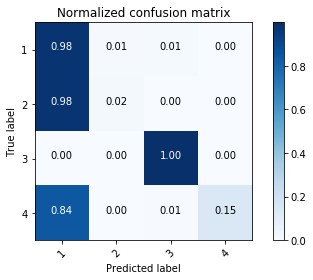

In [13]:
"""Confusion matrix on Trained data"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
s1_train_set_s1nn_predict = cross_val_predict(nn_clf, s1_train_set_s1nn_features, s1_train_set_s1nn_labels.values.ravel(), cv=3)
s1nn_conf_mx = confusion_matrix(s1_train_set_s1nn_labels.values.ravel(), s1_train_set_s1nn_predict)
plt.figure()
class_names = [1,2,3,4]
plot_confusion_matrix(s1nn_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [14]:
for index, activity in [(0, "sit on bed"), (1, "sit on chair"), (2, "lying"), (3, "ambulating")]:
    precision = s1nn_conf_mx[index,index]/sum(s1nn_conf_mx[:,index])
    recall = s1nn_conf_mx[index,index]/sum(s1nn_conf_mx[index,:])
    print(activity + " precision: " + str(precision))
    print(activity + " recall: " + str(recall))

sit on bed precision: 0.713613607575849
sit on bed recall: 0.9768805218396499
sit on chair precision: 0.328042328042328
sit on chair recall: 0.017709225935447014
lying precision: 0.9931100785130588
lying recall: 0.9993147648030957
ambulating precision: 0.8972332015810277
ambulating recall: 0.14514066496163683
